In [9]:
import pandas as pd
import numpy as np
import os, sys, joblib
import math
from scipy import stats
import category_encoders as ce
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GLOBALS
LOCAL_ROOT = "/kaggle/input/"
OUT_DIR = '/kaggle/working/'
DATA_DIR = os.path.join(LOCAL_ROOT, 'machinehack-housepricepredictionchallenge')
TRAIN_FN = os.path.join(DATA_DIR, 'Train.csv')
TEST_FN = os.path.join(DATA_DIR, 'Test.csv')
SUBMISSION_FN = os.path.join(DATA_DIR, 'sample_submission.csv')

In [3]:
# read data
df_train = pd.read_csv(TRAIN_FN)
df_test = pd.read_csv(TEST_FN)

print(df_train.shape, '\t', df_test.shape)
print(df_train.head())

(29451, 12) 	 (68720, 11)
  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   

   READY_TO_MOVE  RESALE                      ADDRESS  LONGITUDE   LATITUDE  \
0              1       1        Ksfc Layout,Bangalore  12.969910  77.597960   
1              1       1    Vishweshwara Nagar,Mysore  12.274538  76.644605   
2              1       1             Jigani,Bangalore  12.778033  77.632191   
3              1       1  Sector-1 Vaishali,Ghaziabad  28.642300  77.344500   
4              0       1             New Town,Kolkata  22.592200  88.484911   

   TARGET(PRICE_IN_LACS)  
0                   55.0  
1     

In [4]:
# combine train and test dfs
df_test['TARGET(PRICE_IN_LACS)'] = None
df_test['sample'] = 'test'
df_train['sample'] = 'train'
cols = list(df_test.columns)
df = pd.concat([df_train[cols], df_test[cols]], axis=0)
df.reset_index(drop=True, inplace=True)
df['TARGET(PRICE_IN_LACS)'] = df['TARGET(PRICE_IN_LACS)'].astype(float)

## Preprocessing
1. log transform the target variable and check if outlier treatment is needed
2. Encode POSTED_BY, BHK_OR_RK with labelEncoder
3. Group BHK_NO. - >=7 as one category
4. Round SQUARE_FT to the nearest 10s place
5. Split Address into location and city and encode them
6. Raw latitude and longitude values converted to radians
7. Perform clustering on latitude and longitude values and use cluster ids as categorical features

In [5]:
# GLOBAL VARS
DV = 'TARGET(PRICE_IN_LACS)'
DV_TRANS = 'dv_trans'

In [6]:
# transform DV
mask = df['sample'] == 'train'
df.loc[mask, DV_TRANS] = df.loc[mask, DV].apply(lambda x: math.log(x+1))

print(df[[DV, DV_TRANS]].head())
print(df[DV_TRANS].describe())

   TARGET(PRICE_IN_LACS)  dv_trans
0                   55.0  4.025352
1                   51.0  3.951244
2                   43.0  3.784190
3                   62.5  4.151040
4                   60.5  4.119037
count    29451.000000
mean         4.230747
std          0.884970
min          0.223144
25%          3.663562
50%          4.143135
75%          4.615121
max         10.308986
Name: dv_trans, dtype: float64


Text(0.5, 1.0, 'Histogram of Log Transformed DV')

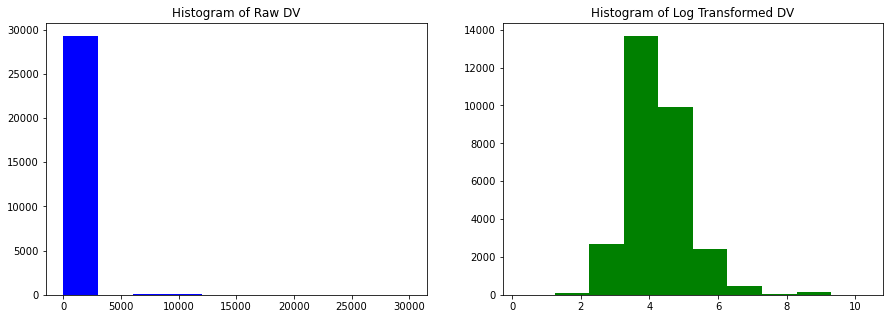

In [7]:
mask = df['sample'] == 'train'
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(x=df.loc[mask, DV], color='blue', label='Raw DV')
#plt.legend()
plt.title('Histogram of Raw DV')

plt.subplot(1, 2, 2)
plt.hist(x=df.loc[mask, DV_TRANS], color='green', label='Log Transformed DV')
#plt.legend()
plt.title('Histogram of Log Transformed DV')

Text(0.5, 1.0, 'Boxplot of Log Transformed DV')

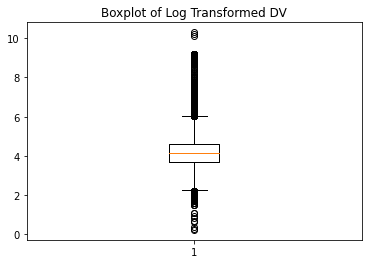

In [8]:
mask = df['sample'] == 'train'
plt.boxplot(x=df.loc[mask, DV_TRANS])
plt.title('Boxplot of Log Transformed DV')

Text(0.5, 1.0, 'Histogram of BoxCox Transformed SQUARE_FT')

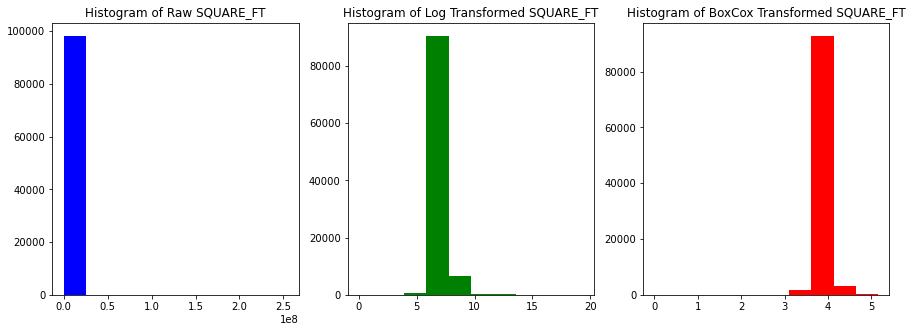

In [16]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(x=df['SQUARE_FT'], color='blue', label='Raw SQUARE_FT')
#plt.legend()
plt.title('Histogram of Raw SQUARE_FT')

plt.subplot(1, 3, 2)
plt.hist(x=df['SQUARE_FT'].apply(math.log), color='green', label='Log Transformed SQUARE_FT')
#plt.legend()
plt.title('Histogram of Log Transformed SQUARE_FT')

plt.subplot(1, 3, 3)
plt.hist(x=stats.boxcox(df['SQUARE_FT'].values)[0], color='red', label='BoxCox Transformed SQUARE_FT')
plt.title('Histogram of BoxCox Transformed SQUARE_FT')

Text(0.5, 1.0, 'Boxplot of BoxCox Transformed SQUARE_FT')

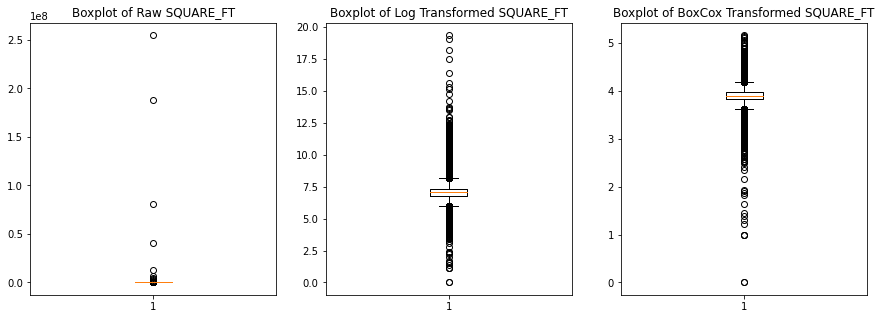

In [20]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(x=df['SQUARE_FT'])
#plt.legend()
plt.title('Boxplot of Raw SQUARE_FT')

plt.subplot(1, 3, 2)
plt.boxplot(x=df['SQUARE_FT'].apply(math.log))
#plt.legend()
plt.title('Boxplot of Log Transformed SQUARE_FT')

plt.subplot(1, 3, 3)
plt.boxplot(x=stats.boxcox(df['SQUARE_FT'].values)[0])
plt.title('Boxplot of BoxCox Transformed SQUARE_FT')

In [21]:
# apply boxcox transformation on SQUARE_FT
df['SQUARE_FT'] = stats.boxcox(df['SQUARE_FT'].values)[0]

In [23]:
# Encode POSTED_BY, BHK_OR_RK
posted_by_map = {'Dealer': 0, 'Owner': 1, 'Builder': 2}
bhk_or_rk_map = {'BHK': 0, 'RK': 1}

df['POSTED_BY'] = df['POSTED_BY'].apply(lambda x: posted_by_map[x])
df['BHK_OR_RK'] = df['BHK_OR_RK'].apply(lambda x: bhk_or_rk_map[x])

In [24]:
df['BHK_NO.'] = df['BHK_NO.'].apply(lambda x: x if x < 7 else 7)

print(df['BHK_NO.'].value_counts())
mask = df['sample'] == 'train'
print(df.loc[mask, 'BHK_NO.'].value_counts())
print(df.loc[~mask, 'BHK_NO.'].value_counts())

2    44322
3    35302
1    11957
4     5724
5      584
6      158
7      124
Name: BHK_NO., dtype: int64
2    13324
3    10546
1     3574
4     1723
5      190
6       52
7       42
Name: BHK_NO., dtype: int64
2    30998
3    24756
1     8383
4     4001
5      394
6      106
7       82
Name: BHK_NO., dtype: int64


In [25]:
# split address into location and city
df['location'] = df['ADDRESS'].apply(
    lambda x: x.split(',')[0].strip().lower())
df['city'] = df['ADDRESS'].apply(
    lambda x: x.split(',')[-1].strip().lower())

In [26]:
from sklearn.preprocessing import LabelEncoder
le_pipes = []

for col in ['city', 'location']:
    le = LabelEncoder()
    le.fit(df[col].values)

    df[col] = le.transform(df[col].values)
    le_pipes.append((col, le))

In [27]:
# convert latitude and longitude to radians
df['lat_rad'] = np.radians(df['LATITUDE'])
df['long_rad'] = np.radians(df['LONGITUDE'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 1.0, 'Elbow Method For Optimal k')

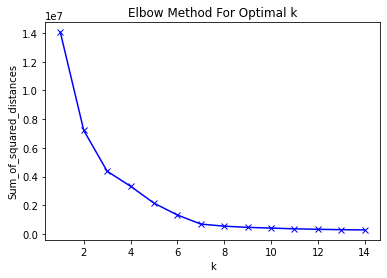

In [28]:
### Clustering
from sklearn.cluster import KMeans

# find optimal number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(df[['LATITUDE', 'LONGITUDE']])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

### Optimal # clusters = 8

In [29]:
kmeans = KMeans(8)
clusters = kmeans.fit_predict(df[['LATITUDE', 'LONGITUDE']])
df['lat_long_cluster'] = kmeans.predict(df[['LATITUDE', 'LONGITUDE']])

Text(0.5, 1.0, 'Scatterplot of latitude and longitude')

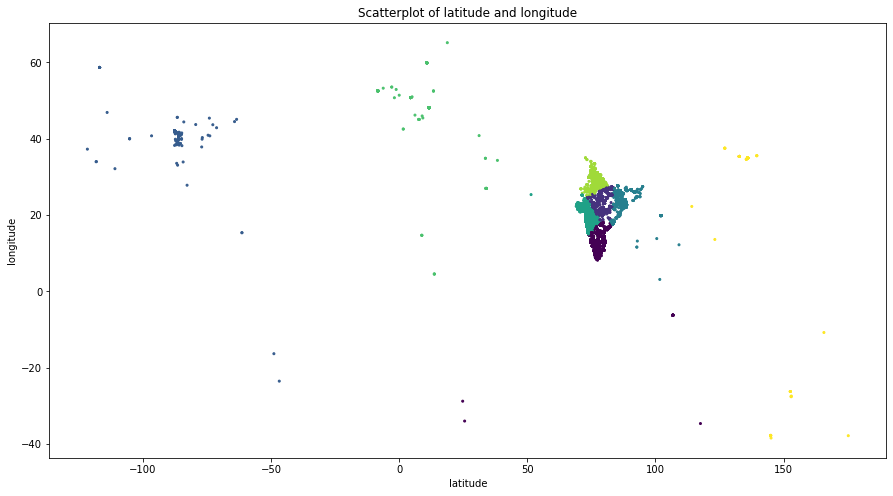

In [30]:
plt.figure(figsize = (15,8))
plt.scatter(df['LATITUDE'], df['LONGITUDE'], s=4, marker='o',
            c=df['lat_long_cluster'])
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Scatterplot of latitude and longitude')

In [31]:
# drop unwanted cols
df.drop(['ADDRESS', 'LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

print(df.columns)

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'TARGET(PRICE_IN_LACS)',
       'sample', 'dv_trans', 'location', 'city', 'lat_rad', 'long_rad',
       'lat_long_cluster'],
      dtype='object')


In [32]:
CAT_COLS = ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.',
            'BHK_OR_RK', 'READY_TO_MOVE', 'RESALE',
            'location', 'city', 'lat_long_cluster']
NUM_COLS = ['SQUARE_FT', 'lat_rad', 'long_rad']

In [33]:
for cat_var in CAT_COLS:
    for num_var in NUM_COLS:
        for func in ['mean', 'min', 'max', 'nunique']:
            feat_name = '_'.join([func, num_var, 'per', cat_var])
            print(feat_name)
            df[feat_name] = df.groupby([cat_var])[num_var].transform(func)
            print('\n')

mean_SQUARE_FT_per_POSTED_BY


min_SQUARE_FT_per_POSTED_BY


max_SQUARE_FT_per_POSTED_BY


nunique_SQUARE_FT_per_POSTED_BY


mean_lat_rad_per_POSTED_BY


min_lat_rad_per_POSTED_BY


max_lat_rad_per_POSTED_BY


nunique_lat_rad_per_POSTED_BY


mean_long_rad_per_POSTED_BY


min_long_rad_per_POSTED_BY


max_long_rad_per_POSTED_BY


nunique_long_rad_per_POSTED_BY


mean_SQUARE_FT_per_UNDER_CONSTRUCTION


min_SQUARE_FT_per_UNDER_CONSTRUCTION


max_SQUARE_FT_per_UNDER_CONSTRUCTION


nunique_SQUARE_FT_per_UNDER_CONSTRUCTION


mean_lat_rad_per_UNDER_CONSTRUCTION


min_lat_rad_per_UNDER_CONSTRUCTION


max_lat_rad_per_UNDER_CONSTRUCTION


nunique_lat_rad_per_UNDER_CONSTRUCTION


mean_long_rad_per_UNDER_CONSTRUCTION


min_long_rad_per_UNDER_CONSTRUCTION


max_long_rad_per_UNDER_CONSTRUCTION


nunique_long_rad_per_UNDER_CONSTRUCTION


mean_SQUARE_FT_per_RERA


min_SQUARE_FT_per_RERA


max_SQUARE_FT_per_RERA


nunique_SQUARE_FT_per_RERA


mean_lat_rad_per_RERA


min_lat_rad_per_RERA


max_lat_rad_pe

In [34]:
for cat_var in CAT_COLS:
    print(cat_var)
    df[cat_var+'_count'] = df.groupby(cat_var)['lat_rad'].transform('count')

POSTED_BY
UNDER_CONSTRUCTION
RERA
BHK_NO.
BHK_OR_RK
READY_TO_MOVE
RESALE
location
city
lat_long_cluster


In [35]:
print('encoding cat_vars by counting the number/percentage of unique cat_vars\n')            
for cat_var in CAT_COLS:
    for cat_var1 in CAT_COLS:
        if cat_var1 != cat_var:
            feat_name = '_'.join(['nunique', cat_var1, 'per', cat_var])
            print(feat_name)
            df[feat_name] = df.groupby([cat_var])[cat_var1].transform('nunique')
            print('\n')
            feat_name_new = '_'.join(['percunique', cat_var1, 'per', cat_var])
            print(feat_name_new)
            df[feat_name_new] = 1.*df[feat_name]/df[cat_var1].nunique()
            print('\n')
            if df[cat_var1].nunique() == 2:
                for func in ['mean', 'sum']:
                    feat_name = '_'.join([func, cat_var1, 'per', cat_var])
                    print(feat_name)
                    df[feat_name] = df.groupby([cat_var])[cat_var1].transform(func)
                    print('\n')

encoding cat_vars by counting the number/percentage of unique cat_vars

nunique_UNDER_CONSTRUCTION_per_POSTED_BY


percunique_UNDER_CONSTRUCTION_per_POSTED_BY


mean_UNDER_CONSTRUCTION_per_POSTED_BY


sum_UNDER_CONSTRUCTION_per_POSTED_BY


nunique_RERA_per_POSTED_BY


percunique_RERA_per_POSTED_BY


mean_RERA_per_POSTED_BY


sum_RERA_per_POSTED_BY


nunique_BHK_NO._per_POSTED_BY


percunique_BHK_NO._per_POSTED_BY


nunique_BHK_OR_RK_per_POSTED_BY


percunique_BHK_OR_RK_per_POSTED_BY


mean_BHK_OR_RK_per_POSTED_BY


sum_BHK_OR_RK_per_POSTED_BY


nunique_READY_TO_MOVE_per_POSTED_BY


percunique_READY_TO_MOVE_per_POSTED_BY


mean_READY_TO_MOVE_per_POSTED_BY


sum_READY_TO_MOVE_per_POSTED_BY


nunique_RESALE_per_POSTED_BY


percunique_RESALE_per_POSTED_BY


mean_RESALE_per_POSTED_BY


sum_RESALE_per_POSTED_BY


nunique_location_per_POSTED_BY


percunique_location_per_POSTED_BY


nunique_city_per_POSTED_BY


percunique_city_per_POSTED_BY


nunique_lat_long_cluster_per_POSTED_BY


percunique



nunique_READY_TO_MOVE_per_lat_long_cluster


percunique_READY_TO_MOVE_per_lat_long_cluster


mean_READY_TO_MOVE_per_lat_long_cluster


sum_READY_TO_MOVE_per_lat_long_cluster


nunique_RESALE_per_lat_long_cluster


percunique_RESALE_per_lat_long_cluster


mean_RESALE_per_lat_long_cluster


sum_RESALE_per_lat_long_cluster


nunique_location_per_lat_long_cluster


percunique_location_per_lat_long_cluster


nunique_city_per_lat_long_cluster


percunique_city_per_lat_long_cluster




In [36]:
from itertools import combinations

print('encoding cat_vars interactions by aggregating numeric vars\n')
iter_cat_vars = list(combinations(CAT_COLS, 2))
print(len(iter_cat_vars))
for f1, f2 in iter_cat_vars:
    for num_var in NUM_COLS:
        for func in ['mean']:
            feat_name = '_'.join([func, num_var, 'per', f1, f2])
            print(feat_name)
            df[feat_name] = df.groupby([f1, f2])[num_var].transform(func)
            print('\n')

encoding cat_vars interactions by aggregating numeric vars

45
mean_SQUARE_FT_per_POSTED_BY_UNDER_CONSTRUCTION


mean_lat_rad_per_POSTED_BY_UNDER_CONSTRUCTION


mean_long_rad_per_POSTED_BY_UNDER_CONSTRUCTION


mean_SQUARE_FT_per_POSTED_BY_RERA


mean_lat_rad_per_POSTED_BY_RERA


mean_long_rad_per_POSTED_BY_RERA


mean_SQUARE_FT_per_POSTED_BY_BHK_NO.


mean_lat_rad_per_POSTED_BY_BHK_NO.


mean_long_rad_per_POSTED_BY_BHK_NO.


mean_SQUARE_FT_per_POSTED_BY_BHK_OR_RK


mean_lat_rad_per_POSTED_BY_BHK_OR_RK


mean_long_rad_per_POSTED_BY_BHK_OR_RK


mean_SQUARE_FT_per_POSTED_BY_READY_TO_MOVE


mean_lat_rad_per_POSTED_BY_READY_TO_MOVE


mean_long_rad_per_POSTED_BY_READY_TO_MOVE


mean_SQUARE_FT_per_POSTED_BY_RESALE


mean_lat_rad_per_POSTED_BY_RESALE


mean_long_rad_per_POSTED_BY_RESALE


mean_SQUARE_FT_per_POSTED_BY_location


mean_lat_rad_per_POSTED_BY_location


mean_long_rad_per_POSTED_BY_location


mean_SQUARE_FT_per_POSTED_BY_city


mean_lat_rad_per_POSTED_BY_city


mean_long_rad_per_POS

In [37]:
for f1, f2 in iter_cat_vars:
    for cat_var in CAT_COLS:
        for func in ['nunique', 'mean', 'sum']:
            if (df[cat_var].nunique() != 2) and (func != 'nunique'):
                continue
            feat_name = '_'.join([func, cat_var, 'per', f1, f2])
            print(feat_name)
            df[feat_name] = df.groupby([f1, f2])[cat_var].transform(func)
            print('\n')
        feat_name_new = '_'.join(['percunique', cat_var, 'per', f1, f2])
        feat_name = '_'.join(['nunique', cat_var, 'per', f1, f2])
        df[feat_name_new] = 1.*df[feat_name]/df[cat_var].nunique()
            
print('encoding cat_vars interactions by counts\n')
for f1, f2 in iter_cat_vars:
        for func in ['count']:
            feat_name = '_'.join([func, 'per', f1, f2])
            print(feat_name)
            df[feat_name] = df.groupby([f1, f2])[f1].transform(func)
            print('\n')

nunique_POSTED_BY_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_UNDER_CONSTRUCTION_per_POSTED_BY_UNDER_CONSTRUCTION


mean_UNDER_CONSTRUCTION_per_POSTED_BY_UNDER_CONSTRUCTION


sum_UNDER_CONSTRUCTION_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_RERA_per_POSTED_BY_UNDER_CONSTRUCTION


mean_RERA_per_POSTED_BY_UNDER_CONSTRUCTION


sum_RERA_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_BHK_NO._per_POSTED_BY_UNDER_CONSTRUCTION


nunique_BHK_OR_RK_per_POSTED_BY_UNDER_CONSTRUCTION


mean_BHK_OR_RK_per_POSTED_BY_UNDER_CONSTRUCTION


sum_BHK_OR_RK_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_READY_TO_MOVE_per_POSTED_BY_UNDER_CONSTRUCTION


mean_READY_TO_MOVE_per_POSTED_BY_UNDER_CONSTRUCTION


sum_READY_TO_MOVE_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_RESALE_per_POSTED_BY_UNDER_CONSTRUCTION


mean_RESALE_per_POSTED_BY_UNDER_CONSTRUCTION


sum_RESALE_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_location_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_city_per_POSTED_BY_UNDER_CONSTRUCTION


nunique_lat_long_clus



sum_BHK_OR_RK_per_UNDER_CONSTRUCTION_RERA


nunique_READY_TO_MOVE_per_UNDER_CONSTRUCTION_RERA


mean_READY_TO_MOVE_per_UNDER_CONSTRUCTION_RERA


sum_READY_TO_MOVE_per_UNDER_CONSTRUCTION_RERA


nunique_RESALE_per_UNDER_CONSTRUCTION_RERA


mean_RESALE_per_UNDER_CONSTRUCTION_RERA


sum_RESALE_per_UNDER_CONSTRUCTION_RERA


nunique_location_per_UNDER_CONSTRUCTION_RERA


nunique_city_per_UNDER_CONSTRUCTION_RERA


nunique_lat_long_cluster_per_UNDER_CONSTRUCTION_RERA


nunique_POSTED_BY_per_UNDER_CONSTRUCTION_BHK_NO.


nunique_UNDER_CONSTRUCTION_per_UNDER_CONSTRUCTION_BHK_NO.


mean_UNDER_CONSTRUCTION_per_UNDER_CONSTRUCTION_BHK_NO.


sum_UNDER_CONSTRUCTION_per_UNDER_CONSTRUCTION_BHK_NO.


nunique_RERA_per_UNDER_CONSTRUCTION_BHK_NO.


mean_RERA_per_UNDER_CONSTRUCTION_BHK_NO.


sum_RERA_per_UNDER_CONSTRUCTION_BHK_NO.


nunique_BHK_NO._per_UNDER_CONSTRUCTION_BHK_NO.


nunique_BHK_OR_RK_per_UNDER_CONSTRUCTION_BHK_NO.


mean_BHK_OR_RK_per_UNDER_CONSTRUCTION_BHK_NO.


sum_BHK_OR_RK_per_UNDER_CONST



sum_RESALE_per_RERA_BHK_NO.


nunique_location_per_RERA_BHK_NO.


nunique_city_per_RERA_BHK_NO.


nunique_lat_long_cluster_per_RERA_BHK_NO.


nunique_POSTED_BY_per_RERA_BHK_OR_RK


nunique_UNDER_CONSTRUCTION_per_RERA_BHK_OR_RK


mean_UNDER_CONSTRUCTION_per_RERA_BHK_OR_RK


sum_UNDER_CONSTRUCTION_per_RERA_BHK_OR_RK


nunique_RERA_per_RERA_BHK_OR_RK


mean_RERA_per_RERA_BHK_OR_RK


sum_RERA_per_RERA_BHK_OR_RK


nunique_BHK_NO._per_RERA_BHK_OR_RK


nunique_BHK_OR_RK_per_RERA_BHK_OR_RK


mean_BHK_OR_RK_per_RERA_BHK_OR_RK


sum_BHK_OR_RK_per_RERA_BHK_OR_RK


nunique_READY_TO_MOVE_per_RERA_BHK_OR_RK


mean_READY_TO_MOVE_per_RERA_BHK_OR_RK


sum_READY_TO_MOVE_per_RERA_BHK_OR_RK


nunique_RESALE_per_RERA_BHK_OR_RK


mean_RESALE_per_RERA_BHK_OR_RK


sum_RESALE_per_RERA_BHK_OR_RK


nunique_location_per_RERA_BHK_OR_RK


nunique_city_per_RERA_BHK_OR_RK


nunique_lat_long_cluster_per_RERA_BHK_OR_RK


nunique_POSTED_BY_per_RERA_READY_TO_MOVE


nunique_UNDER_CONSTRUCTION_per_RERA_READY_TO_MOVE


me



nunique_READY_TO_MOVE_per_BHK_NO._city


mean_READY_TO_MOVE_per_BHK_NO._city


sum_READY_TO_MOVE_per_BHK_NO._city


nunique_RESALE_per_BHK_NO._city


mean_RESALE_per_BHK_NO._city


sum_RESALE_per_BHK_NO._city


nunique_location_per_BHK_NO._city


nunique_city_per_BHK_NO._city


nunique_lat_long_cluster_per_BHK_NO._city


nunique_POSTED_BY_per_BHK_NO._lat_long_cluster


nunique_UNDER_CONSTRUCTION_per_BHK_NO._lat_long_cluster


mean_UNDER_CONSTRUCTION_per_BHK_NO._lat_long_cluster


sum_UNDER_CONSTRUCTION_per_BHK_NO._lat_long_cluster


nunique_RERA_per_BHK_NO._lat_long_cluster


mean_RERA_per_BHK_NO._lat_long_cluster


sum_RERA_per_BHK_NO._lat_long_cluster


nunique_BHK_NO._per_BHK_NO._lat_long_cluster


nunique_BHK_OR_RK_per_BHK_NO._lat_long_cluster


mean_BHK_OR_RK_per_BHK_NO._lat_long_cluster


sum_BHK_OR_RK_per_BHK_NO._lat_long_cluster


nunique_READY_TO_MOVE_per_BHK_NO._lat_long_cluster


mean_READY_TO_MOVE_per_BHK_NO._lat_long_cluster


sum_READY_TO_MOVE_per_BHK_NO._lat_long_clust



nunique_READY_TO_MOVE_per_READY_TO_MOVE_lat_long_cluster


mean_READY_TO_MOVE_per_READY_TO_MOVE_lat_long_cluster


sum_READY_TO_MOVE_per_READY_TO_MOVE_lat_long_cluster


nunique_RESALE_per_READY_TO_MOVE_lat_long_cluster


mean_RESALE_per_READY_TO_MOVE_lat_long_cluster


sum_RESALE_per_READY_TO_MOVE_lat_long_cluster


nunique_location_per_READY_TO_MOVE_lat_long_cluster


nunique_city_per_READY_TO_MOVE_lat_long_cluster


nunique_lat_long_cluster_per_READY_TO_MOVE_lat_long_cluster


nunique_POSTED_BY_per_RESALE_location


nunique_UNDER_CONSTRUCTION_per_RESALE_location


mean_UNDER_CONSTRUCTION_per_RESALE_location


sum_UNDER_CONSTRUCTION_per_RESALE_location


nunique_RERA_per_RESALE_location


mean_RERA_per_RESALE_location


sum_RERA_per_RESALE_location


nunique_BHK_NO._per_RESALE_location


nunique_BHK_OR_RK_per_RESALE_location


mean_BHK_OR_RK_per_RESALE_location


sum_BHK_OR_RK_per_RESALE_location


nunique_READY_TO_MOVE_per_RESALE_location


mean_READY_TO_MOVE_per_RESALE_location



In [38]:
print('split df into train and test\n')
mask = df['sample'] == 'train'
df_train = df.loc[mask, :]
df_train.reset_index(drop=True, inplace=True)
df_test = df.loc[~mask, :]
df_test.reset_index(drop=True, inplace=True)
df_train.drop(['sample'], axis=1, inplace=True)
df_test.drop(['sample', DV, DV_TRANS], axis=1, inplace=True)

split df into train and test



/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
print('release memory\n')
del df

release memory



In [40]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [41]:
from sklearn.model_selection import KFold


def getCountVar(compute_df, count_df, var_name, count_var):
    """
    compute_df : Data frame for which the count encoding should be done
    count_df : Data frame from which the counts should be taken
    var_name : categorical variable for count encoding
    count_var : some other variable from the dataset (used as dummy variable to get count)
    """
    grouped_df = count_df.groupby(var_name, as_index=False)[count_var].agg('count')
    grouped_df.columns = [var_name, "var_count"]
    merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
    merged_df.fillna(-1, inplace=True)
    return list(merged_df["var_count"])


def getDVEncodeVar(compute_df, target_df, var_name, target_var):
    if type(var_name) != type([]):
        var_name = [var_name]
    grouped_df = target_df.groupby(var_name)[target_var].agg(["mean"]).reset_index()
    grouped_df.columns = var_name + ["mean_value"]
    merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
    merged_df.fillna(-1, inplace=True)
    return list(merged_df["mean_value"])


def do_target_encode(train_df, test_df, cols_to_encode, target_col, encode_type, n_splits=3):
        
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2020)
    for col in cols_to_encode:
        print(col)
        train_enc_values = np.zeros(train_df.shape[0])
        test_enc_values = 0
        for dev_index, val_index in kf.split(train_df):
            new_train_df = train_df[[col, target_col]]
            dev_X, val_X = new_train_df.iloc[dev_index], new_train_df.iloc[val_index]
            
            if encode_type == 'dv':
                train_enc_values[val_index] =  np.array( 
                    getDVEncodeVar(val_X[[col]], dev_X, col, target_col))
                test_enc_values += np.array( 
                    getDVEncodeVar(test_df[[col]], dev_X, col, target_col))
            elif encode_type == 'count':
                train_enc_values[val_index] =  np.array( 
                    getCountVar(val_X[[col]], dev_X, col, target_col))
                test_enc_values += np.array( 
                    getCountVar(test_df[[col]], dev_X, col, target_col))
        
        test_enc_values /= n_splits
        train_df[col + "_{}_enc_{}".format(encode_type, target_col)] = train_enc_values
        test_df[col + "_{}_enc_{}".format(encode_type, target_col)] = test_enc_values
        print('\n')
        
    return train_df, test_df

In [42]:
print('DV encodings\n')
df_train, df_test = do_target_encode(df_train, df_test, CAT_COLS, DV_TRANS, 'dv', 5)

print('shape ', df_train.shape, '\t', df_test.shape)

DV encodings

POSTED_BY


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




UNDER_CONSTRUCTION


RERA


BHK_NO.


BHK_OR_RK


READY_TO_MOVE


RESALE


location


city


lat_long_cluster


shape  (29451, 1955) 	 (68720, 1953)


In [43]:
df_train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'TARGET(PRICE_IN_LACS)',
       'dv_trans',
       ...
       'POSTED_BY_dv_enc_dv_trans', 'UNDER_CONSTRUCTION_dv_enc_dv_trans',
       'RERA_dv_enc_dv_trans', 'BHK_NO._dv_enc_dv_trans',
       'BHK_OR_RK_dv_enc_dv_trans', 'READY_TO_MOVE_dv_enc_dv_trans',
       'RESALE_dv_enc_dv_trans', 'location_dv_enc_dv_trans',
       'city_dv_enc_dv_trans', 'lat_long_cluster_dv_enc_dv_trans'],
      dtype='object', length=1955)

In [44]:
print('prefix for features\n')
FEAT_PREFIX = 'MH'
cols = list(df_train.columns)
new_cols = [FEAT_PREFIX + '_'+ col if col not in (DV, DV_TRANS) else col for col in cols]
rename_dct = dict(zip(cols, new_cols))
df_train.rename(columns=rename_dct, inplace=True)
df_test.rename(columns=rename_dct, inplace=True)

df_train[DV_TRANS] = df_train[DV_TRANS].astype(float)

prefix for features



/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [45]:
feat_cols = [x for x in list(df_train.columns) if x.startswith(FEAT_PREFIX)]
print('# features: ', len(feat_cols))
print('get indices of cat_feats')
cat_feats = [FEAT_PREFIX + '_' + col for col in CAT_COLS]
cat_feats_indices = [i for i, col in enumerate(feat_cols) if col in cat_feats]
print(cat_feats_indices, cat_feats)

# features:  1953
get indices of cat_feats
[0, 1, 2, 3, 4, 6, 7, 8, 9, 12] ['MH_POSTED_BY', 'MH_UNDER_CONSTRUCTION', 'MH_RERA', 'MH_BHK_NO.', 'MH_BHK_OR_RK', 'MH_READY_TO_MOVE', 'MH_RESALE', 'MH_location', 'MH_city', 'MH_lat_long_cluster']


In [46]:
print('prepare data for modelling\n')
x_train = df_train[feat_cols]
y_train = df_train[DV_TRANS]
x_test = df_test[feat_cols]
print('shape ', x_train.shape, x_test.shape)

prepare data for modelling

shape  (29451, 1953) (68720, 1953)


In [47]:
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
import operator


def create_feature_map(features):
    out_fn = os.path.join(OUT_DIR, 'xgb.fmap')
    outfile = open(out_fn, 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None,
           feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "reg:squarederror"
    params['eval_metric'] = "rmse"
    params["eta"] = eta
    params["subsample"] = 0.7
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = dep
    params["alpha"] = 0.3
    params["lambda"] = 0.3
    params["silent"] = 1
    params["seed"] = seed_val
    # params["max_delta_step"] = 2
    # params["gamma"] = 0.5
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
                          early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names)
        xgb_model_fn = os.path.join(OUT_DIR, 'xgbmodel.txt')
        xgb_fmap_fn = os.path.join(OUT_DIR, 'xgb.fmap')
        xgb_imp_fn = os.path.join(OUT_DIR, 'imp_feat.txt')
        model.dump_model(xgb_model_fn, xgb_fmap_fn, with_stats=True)
        importance = model.get_fscore(fmap=xgb_fmap_fn)
        importance = sorted(importance.items(), key=operator.itemgetter(1),
                            reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv(xgb_imp_fn, index=False)

    pred_test_y = model.predict(xgtest,
                                ntree_limit=model.best_ntree_limit)
    pred_test_y_raw = np.exp(pred_test_y) - 1
    if test_X2 is not None:
        pred_test_y2 = model.predict(xgb.DMatrix(test_X2),
                                     ntree_limit=model.best_ntree_limit)
        pred_test_y2_raw = np.exp(pred_test_y2) - 1
    else:
        pred_test_y2 = None

    loss = 0
    if test_y is not None:
        test_y_raw = (np.exp(test_y) - 1).values
        loss = np.sqrt(metrics.mean_squared_log_error(test_y_raw, pred_test_y_raw))

    return pred_test_y_raw, loss, pred_test_y2_raw


def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None,
           feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "regression"
    params['metric'] = "rmse"
    params['seed'] = seed_val
    params['num_threads'] = 4
    params["max_depth"] = dep
    params["num_leaves"] = 50
    params["min_data_in_leaf"] = 50
    params["learning_rate"] = eta
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.7
    params["feature_fraction_seed"] = seed_val
    params["bagging_freq"] = 5
    params["bagging_seed"] = seed_val
    params["lambda_l2"] = 3
    params["lambda_l1"] = 3
    params["verbosity"] = 1
    num_rounds = rounds

    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest],
                          early_stopping_rounds=100, verbose_eval=20)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X,
                                num_iteration=model.best_iteration)
    pred_test_y_raw = np.exp(pred_test_y) - 1
    
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2,
                                     num_iteration=model.best_iteration)
        pred_test_y2_raw = np.exp(pred_test_y2) - 1
    else:
        pred_test_y2 = None
        
    loss = 0
    if test_y is not None:
        test_y_raw = (np.exp(test_y) - 1).values
        loss = np.sqrt(metrics.mean_squared_log_error(test_y_raw, pred_test_y_raw))

    return pred_test_y_raw, loss, pred_test_y2_raw


def runCatboost(train_X, train_y, test_X, test_y=None, test_X2=None, iterations=1500, lr=0.01, depth=8, rsm=0.7,
                cat_feats_index=[]):
    
    params = {}
    params['iterations'] = iterations
    params['learning_rate'] = lr
    params['rsm'] = rsm
    params['random_seed'] = 2020
    params['l2_leaf_reg'] = 3.5
    params['early_stopping_rounds'] = 100
    params['depth'] = depth
    params['subsample'] = 0.7
    params['min_data_in_leaf'] = 10
    params['max_leaves'] = 31
    params['loss_function'] = 'RMSE' 
    params['eval_metric'] = 'RMSE'
    params['use_best_model'] = True
    params['leaf_estimation_method'] = 'Newton'
    params['cat_feats_index'] = cat_feats_index
    
    # init model class
    model = CatBoostRegressor(
        iterations = params['iterations'],
        learning_rate = params['learning_rate'],
        rsm = params['rsm'],
        random_seed = params['random_seed'],
        l2_leaf_reg = params['l2_leaf_reg'],
        early_stopping_rounds = params['early_stopping_rounds'],
        min_data_in_leaf = params['min_data_in_leaf'],
        max_leaves = params['max_leaves'],
        subsample = params['subsample'],
        depth = params['depth'],
        loss_function = params['loss_function'],
        eval_metric = params['eval_metric'],
        use_best_model = params['use_best_model'],
        leaf_estimation_method = params['leaf_estimation_method']
    )
    
    # fit
    model.fit(train_X, train_y, eval_set=(test_X, test_y), cat_features=params['cat_feats_index'])
    
    # predict
    pred_val = model.predict(test_X)
    pred_val_raw = np.exp(pred_val) - 1
    if test_X2 is not None:
        pred_test = model.predict(test_X2)
        pred_test_raw = np.exp(pred_test) - 1
    else:
        pred_test = None
        
    loss = 0
    if test_y is not None:
        test_y_raw = (np.exp(test_y) - 1).values
        loss = np.sqrt(metrics.mean_squared_log_error(test_y_raw, pred_test_raw))
    
    return pred_val_raw, loss, pred_test_raw


def trainModel(train_X, train_y, test_X, n_splits, model_name, feats, **params):
    train_y_raw = (np.exp(train_y) - 1).values
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2020)
    cv_scores = []
    pred_test_full = 0
    pred_val_full = np.zeros(train_X.shape[0])
    for dev_index, val_index in kf.split(train_X):
        dev_X, val_X = train_X.iloc[dev_index, :], train_X.iloc[val_index, :]
        dev_y, val_y = train_y[dev_index], train_y[val_index]

        if model_name == "XGB":
            pred_val, acc, pred_test = runXGB(
             dev_X, dev_y, val_X, val_y, test_X, rounds=params['rounds'],
             dep=params['depth'], eta=params['eta'], feature_names=feats)
        elif model_name == "LGB":
            pred_val, acc, pred_test = runLGB(
             dev_X, dev_y, val_X, val_y, test_X, rounds=params['rounds'],
             dep=params['depth'], eta=params['eta'])
        elif model_name == "CatBoost":
            pred_val, acc, pred_test = runCatboost(
             dev_X, dev_y, val_X, val_y, test_X, iterations=params['rounds'],
             depth=params['depth'], lr=params['eta'], rsm=params['rsm'],
             cat_feats_index=params['cat_feats_index'])
        
        cv_scores.append(acc)
        pred_val_full[val_index] = pred_val
        pred_test_full = pred_test_full + pred_test

    pred_test_full /= n_splits
    rmsle = np.sqrt(metrics.mean_squared_log_error(train_y_raw, pred_val_full))
    return pred_val_full, rmsle, pred_test_full, cv_scores

In [49]:
print('XGB\n')
params = {'rounds': 2000, 'eta': 0.05, 'depth': 6}
%time pred_val_full, rmsle, pred_test_full, cv_scores = trainModel(x_train, y_train, x_test, 5, 'XGB', feat_cols, **params)

XGB

[10:34:21] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.64585	test-rmse:3.64176
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[20]	train-rmse:1.34880	test-rmse:1.34962
[40]	train-rmse:0.55662	test-rmse:0.56919
[60]	train-rmse:0.32000	test-rmse:0.34942
[80]	train-rmse:0.26435	test-rmse:0.30469
[100]	train-rmse:0.24881	test-rmse:0.29513
[120]	train-rmse:0.24082	test-rmse:0.29215
[140]	train-rmse:0.23503	test-rmse:0.29018
[160]	train-rmse:0.23005	test-rmse:0.28910
[180]	train-rmse:0.22540	test-rmse:0.28777
[200]	train-rmse:0.22049	test-rmse:0.28675
[220]	train-rmse:0.21646	test-rmse:0.28578
[240]	train-rms

[900]	train-rmse:0.14634	test-rmse:0.26191
[920]	train-rmse:0.14499	test-rmse:0.26190
[940]	train-rmse:0.14374	test-rmse:0.26199
[960]	train-rmse:0.14249	test-rmse:0.26208
[980]	train-rmse:0.14134	test-rmse:0.26195
[1000]	train-rmse:0.14017	test-rmse:0.26189
[1020]	train-rmse:0.13914	test-rmse:0.26192
[1040]	train-rmse:0.13793	test-rmse:0.26183
[1060]	train-rmse:0.13682	test-rmse:0.26187
[1080]	train-rmse:0.13579	test-rmse:0.26173
[1100]	train-rmse:0.13468	test-rmse:0.26176
[1120]	train-rmse:0.13367	test-rmse:0.26178
[1140]	train-rmse:0.13269	test-rmse:0.26174
[1160]	train-rmse:0.13170	test-rmse:0.26179
[1180]	train-rmse:0.13071	test-rmse:0.26180
[1200]	train-rmse:0.12982	test-rmse:0.26177
[1220]	train-rmse:0.12895	test-rmse:0.26173
[1240]	train-rmse:0.12807	test-rmse:0.26171
[1260]	train-rmse:0.12726	test-rmse:0.26170
[1280]	train-rmse:0.12638	test-rmse:0.26165
[1300]	train-rmse:0.12551	test-rmse:0.26154
[1320]	train-rmse:0.12459	test-rmse:0.26155
[1340]	train-rmse:0.12376	test-rmse:0

In [50]:
cv_scores, rmsle

([0.27674238315047556,
  0.2743373927035674,
  0.2615089453732974,
  0.2790169182182792,
  0.2585169018696538],
 0.27015414856370906)

In [51]:
out_df = pd.DataFrame({DV: pred_test_full})
out_df.to_csv(os.path.join(OUT_DIR, "pred_test_v2_xgb.csv"), index=False)

In [54]:
print('LGB\n')
params = {'rounds': 5000, 'eta': 0.02, 'depth': 7}
%time pred_val_full, rmsle, pred_test_full, cv_scores = trainModel(x_train, y_train, x_test, 5, 'LGB', feat_cols, **params)

LGB

Training until validation scores don't improve for 100 rounds
[20]	valid_0's rmse: 0.660451
[40]	valid_0's rmse: 0.517801
[60]	valid_0's rmse: 0.432926
[80]	valid_0's rmse: 0.382486
[100]	valid_0's rmse: 0.353551
[120]	valid_0's rmse: 0.33473
[140]	valid_0's rmse: 0.323521
[160]	valid_0's rmse: 0.316378
[180]	valid_0's rmse: 0.31165
[200]	valid_0's rmse: 0.308932
[220]	valid_0's rmse: 0.306604
[240]	valid_0's rmse: 0.305117
[260]	valid_0's rmse: 0.303886
[280]	valid_0's rmse: 0.303081
[300]	valid_0's rmse: 0.302143
[320]	valid_0's rmse: 0.301224
[340]	valid_0's rmse: 0.300394
[360]	valid_0's rmse: 0.299734
[380]	valid_0's rmse: 0.299169
[400]	valid_0's rmse: 0.298724
[420]	valid_0's rmse: 0.298272
[440]	valid_0's rmse: 0.297749
[460]	valid_0's rmse: 0.297439
[480]	valid_0's rmse: 0.297196
[500]	valid_0's rmse: 0.296732
[520]	valid_0's rmse: 0.296273
[540]	valid_0's rmse: 0.295877
[560]	valid_0's rmse: 0.295511
[580]	valid_0's rmse: 0.295242
[600]	valid_0's rmse: 0.294974
[620]	val

[1400]	valid_0's rmse: 0.267444
[1420]	valid_0's rmse: 0.267418
[1440]	valid_0's rmse: 0.267293
[1460]	valid_0's rmse: 0.267233
[1480]	valid_0's rmse: 0.26717
[1500]	valid_0's rmse: 0.267161
[1520]	valid_0's rmse: 0.267136
[1540]	valid_0's rmse: 0.267135
[1560]	valid_0's rmse: 0.267076
[1580]	valid_0's rmse: 0.267052
[1600]	valid_0's rmse: 0.266939
[1620]	valid_0's rmse: 0.266874
[1640]	valid_0's rmse: 0.266834
[1660]	valid_0's rmse: 0.266845
[1680]	valid_0's rmse: 0.266791
[1700]	valid_0's rmse: 0.26672
[1720]	valid_0's rmse: 0.266687
[1740]	valid_0's rmse: 0.266642
[1760]	valid_0's rmse: 0.266605
[1780]	valid_0's rmse: 0.266554
[1800]	valid_0's rmse: 0.26652
[1820]	valid_0's rmse: 0.266522
[1840]	valid_0's rmse: 0.266551
[1860]	valid_0's rmse: 0.266474
[1880]	valid_0's rmse: 0.266469
[1900]	valid_0's rmse: 0.266399
[1920]	valid_0's rmse: 0.266424
[1940]	valid_0's rmse: 0.266358
[1960]	valid_0's rmse: 0.26632
[1980]	valid_0's rmse: 0.266337
[2000]	valid_0's rmse: 0.266334
[2020]	valid

[2540]	valid_0's rmse: 0.267639
[2560]	valid_0's rmse: 0.26759
[2580]	valid_0's rmse: 0.267592
[2600]	valid_0's rmse: 0.267591
[2620]	valid_0's rmse: 0.267616
[2640]	valid_0's rmse: 0.267594
[2660]	valid_0's rmse: 0.267604
[2680]	valid_0's rmse: 0.267565
[2700]	valid_0's rmse: 0.267509
[2720]	valid_0's rmse: 0.267484
[2740]	valid_0's rmse: 0.267473
[2760]	valid_0's rmse: 0.267427
[2780]	valid_0's rmse: 0.267491
[2800]	valid_0's rmse: 0.267458
[2820]	valid_0's rmse: 0.267416
[2840]	valid_0's rmse: 0.26742
[2860]	valid_0's rmse: 0.267354
[2880]	valid_0's rmse: 0.267332
[2900]	valid_0's rmse: 0.267319
[2920]	valid_0's rmse: 0.267359
[2940]	valid_0's rmse: 0.267343
[2960]	valid_0's rmse: 0.267373
[2980]	valid_0's rmse: 0.267411
Early stopping, best iteration is:
[2890]	valid_0's rmse: 0.267315
CPU times: user 40min 9s, sys: 19.2 s, total: 40min 28s
Wall time: 10min 39s


In [55]:
cv_scores, rmsle

([0.28714666422618684,
  0.2809849868407425,
  0.26618200269324344,
  0.2857575272479713,
  0.26731535323606503],
 0.27762363146780555)

In [56]:
out_df = pd.DataFrame({DV: pred_test_full})
out_df.to_csv(os.path.join(OUT_DIR, "pred_test_v2_lgb.csv"), index=False)